# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/571/view) for this project.

---

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages, Define Variable Defaults, & Define Some Helper Functions

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import os
import pprint
%matplotlib inline

In [2]:
mtx = None
dist = None

In [3]:
## Function used to undistort images for pipeline
def image_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


## Function to redistort images back to a camera's view
def image_redistort(img, mtx, dist):
    return img

## Camera Calibration

camera_cal\calibration10.jpg


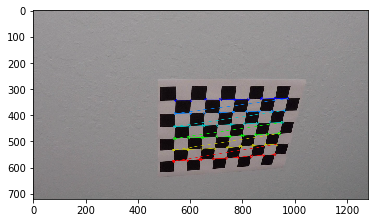

camera_cal\calibration11.jpg


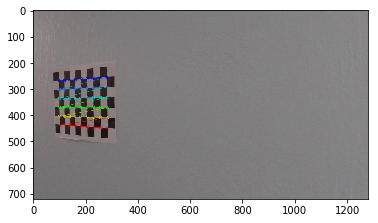

camera_cal\calibration12.jpg


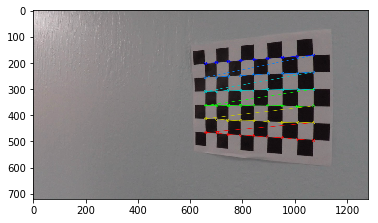

camera_cal\calibration13.jpg


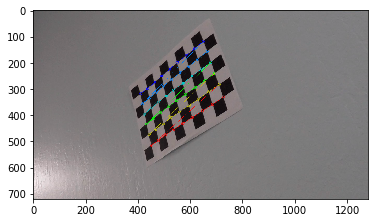

camera_cal\calibration14.jpg


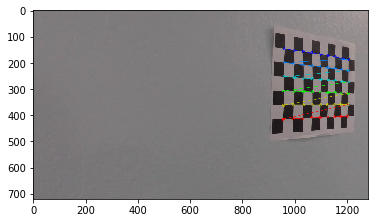

camera_cal\calibration15.jpg


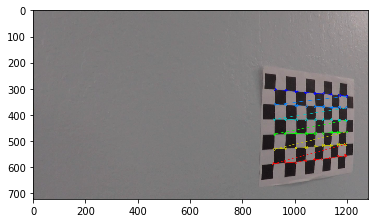

camera_cal\calibration16.jpg


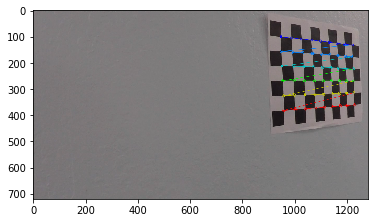

camera_cal\calibration17.jpg


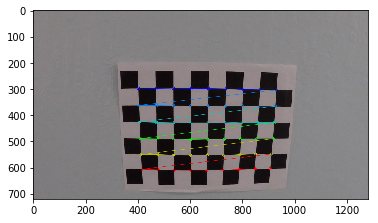

camera_cal\calibration18.jpg


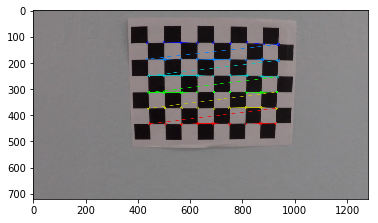

camera_cal\calibration19.jpg


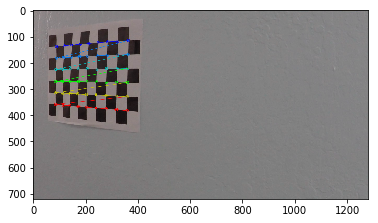

camera_cal\calibration2.jpg


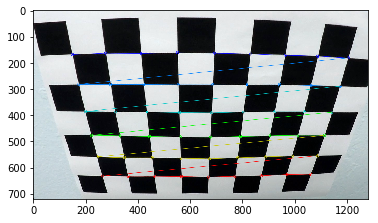

camera_cal\calibration20.jpg


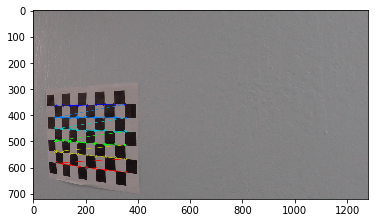

camera_cal\calibration3.jpg


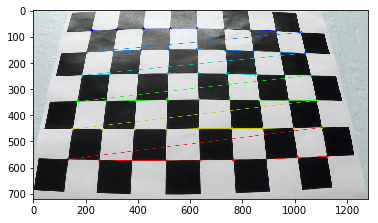

camera_cal\calibration6.jpg


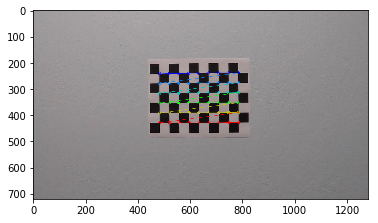

camera_cal\calibration7.jpg


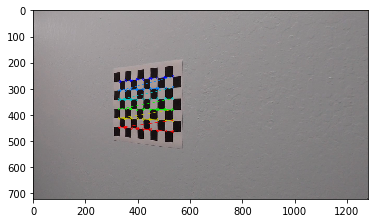

camera_cal\calibration8.jpg


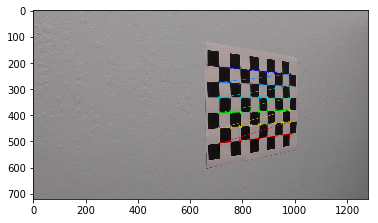

camera_cal\calibration9.jpg


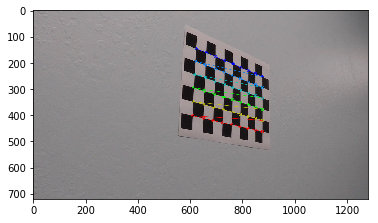

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'output_images/corners_found/corners_found_'+fname.split('\\')[-1]
        cv2.imwrite(write_name, img)
        print(fname)
        plt.imshow(img)
        plt.show()
        #cv2.waitKey(500)

In [5]:
# Test undistortion on an image
imgname = 'calibration1'
fname = 'camera_cal/'+imgname+'.jpg'
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort and save to 'output_images' directory
dst = image_undistort(img, mtx, dist)
cv2.imwrite('output_images/'+imgname+'_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["ret"] = ret
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

## Load Camera Calibration

In [6]:
if mtx is None or dist is None:
    cameraCal = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = cameraCal['mtx']
    dist = cameraCal['dist']
    print('Pickle file was loaded!')

## Helper Functions

### Image Processing

This function is used to calculate the sobel gradient, magnitude, and direction and the color threshold of the image, it returns a binary image.

In [7]:
def process_image(img, orient='x', sobel_thresh=(35,200), s_color_thresh=(120,255), l_color_thresh=(120,255), mag_thresh=(30,255), dir_thresh=(0.7,1.3)):
    ## Histogram equaliztion of images to help with shadows
    # separate RGB channels
    #ch1 = img[:,:,0] # blue channel
    #ch2 = img[:,:,1] # green channel
    #ch3 = img[:,:,2] # red channel

    # apply histogram equalization
    #equ1 = cv2.equalizeHist(ch1)
    #equ2 = cv2.equalizeHist(ch2)
    #equ3 = cv2.equalizeHist(ch3)
    # apply gaussian blur to blue channel
    #equ1 = cv2.GaussianBlur(equ1,(9,9),39)

    # stack, combine channels again
    #histeq = np.dstack((equ1,equ2,equ3))
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    
    # Sobel direction
    graddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    #scaled_graddir = np.uint8(255*graddir/np.max(graddir))

    # Threshold x gradient
    thresh_min = sobel_thresh[0]
    thresh_max = sobel_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold sobel magnitude
    mag_min = mag_thresh[0]
    mag_max = mag_thresh[1]
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= mag_min) & (scaled_gradmag <= mag_max)] = 1
    
    # Threshold sobel direction
    dir_min = dir_thresh[0]
    dir_max = dir_thresh[1]
    dir_binary = np.zeros_like(graddir)
    dir_binary[(graddir >= dir_min) & (graddir <= dir_max)] = 1

    # Threshold s channel
    s_thresh_min = s_color_thresh[0]
    s_thresh_max = s_color_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold l channel
    l_thresh_min = l_color_thresh[0]
    l_thresh_max = l_color_thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    mag_dir_binary = np.zeros_like(mag_binary)
    mag_dir_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
    sl_binary = np.zeros_like(s_binary)
    sl_binary[(s_binary == 1) & (l_binary == 1)] = 1
    color_binary = np.dstack((mag_dir_binary, sxbinary, sl_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1 | ((mag_binary == 1) & (dir_binary == 1))) | ((s_binary == 1) & (l_binary == 1))] = 1

    return [combined_binary, color_binary]

### Perspective Transform

To determine the src and dst points, one of the test images needs to be analyzed.  The same transform is then used on all of the images from here on out.

These two functions takes an image and warp or unwarp the image to a bird's eye view.

In [8]:
def perspective_transform(img):
    # Get image size
    img_size = (img.shape[1], img.shape[0])
    
    # Define constants for perspective transform
    offset = 300
    src = np.float32([[595, 450],                               # Left    Top
                      [685, 450],                               # Right   Top
                      [1125, img_size[1]],                      # Right   Bottom
                      [180, img_size[1]]])                      # Left    Bottom
    dst = np.float32([[offset, 0],                              # Left    Top
                      [img_size[0]-offset, 0],                  # Right   Top
                      [img_size[0]-offset, img_size[1]],        # Right   Bottom
                      [offset, img_size[1]]])                   # Left    Bottom
    
    # Determine transform matrices
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Transform image
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return [warped_img, M, Minv]

def perspective_untransform(img, Minv):
    # Get image size
    img_size = (img.shape[1], img.shape[0])
    
    # Unwarp Image
    unwarped_img = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped_img

### Line Helper Class

This class is used to track and maintain information about a lane line in an image. It stores past data on the line and has all of the helper functions built in.

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, side='left'):
        
        ### Instance Definitions/constants
        
        # set the side so it knows which side of the image to start on
        # 'left' or 'right'
        if (side == 'left' ) or (side == 'right'):
            self.side = side
        else:
            self.side = 'left'
            
        # number of frames to average
        self.n_average = 5
        
        # window values for searching
        self.window_width = 150
        self.window_height = 80
        self.window_margin = 50
        self.min_pixel = 50
        
        # Image size, should remain constant
        self.image_size = None
        
        
        ### Latest values
        
        # Current Frame number
        self.current_Frame = 1
        
        # was the line detected in the last iteration?
        self.detected_Last = False
        
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        self.current_x = None
        self.current_y = None
        
        # radius of curvature of the line in some units
        self.radius_of_curvature_pixels = None
        self.radius_of_curvature_meters = None
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        # window return values
        self.window_centroids = []
        
        # indices of lane pixels
        self.lane_inds = []
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        
        
        ### Average values
        
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        # polynomial coefficient values of the last n fits of the line
        self.recent_fits = [] 
        
        
        ### Difference values
        
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        
        
        
    ### External methods    
        
    # Function for setting the 'detected_Last' property
    def set_detected(self, value=True):
        self.detected_Last = value
    
    # Function for changing the 'side' property, could be used later for when a driver switches lanes
    def set_side(self, value):
        if (value == 'left' ) or (value == 'right'):
            self.side = value
        else:
            self.side = 'left'
    
    # Function for choosing whether to search for a fresh line or do a targeted search
    def searchLine(self, img):
        # Choose between two different methods for finding lines based 
        # on whether a valid line was found in that last iteration or not
        if self.detected_Last:
            self._searchLine_Targeted(img)
        else:
            self._searchLine_Fresh(img)
            
    # Function for checking the validity of the new found line
    def checkValidity(self):
        self.diffs = np.array([0,0,0], dtype='float')
        
        if self.current_fit is [np.array([False])]:
            self.detected_Last = False
        else:
            self.detected_Last = True            
            
    # Function for updating any average parameters with the latest values
    def updateAverages(self):
        if self.best_fit is None:
            self.recent_fits.append(self.current_fit)
            self.best_fit = self.current_fit
        else:
            if len(self.recent_fits) == self.n_average:
                self.recent_fits.remove(self.recent_fits[0])
            self.recent_fits.append(self.current_fit)
            weights=range(len(self.recent_fits),0,-1)
            self.best_fit = np.average(self.recent_fits, axis=0, weights=weights)
            
        fit = self.best_fit
        self.current_x = fit[0]*self.current_y**2 + fit[1]*self.current_y + fit[2]
            
        if self.bestx is None:
            self.recent_xfitted.append(self.current_x)
            self.bestx = self.current_x
        else:
            if len(self.recent_xfitted) == self.n_average:
                self.recent_xfitted.remove(self.recent_xfitted[0])
            self.recent_xfitted.append(self.current_x)
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            
    # Function for calculating the curvature of the line
    def calcCurvature(self):
        y_eval = np.max(self.current_y)
        fit = self.best_fit
        self.radius_of_curvature_pixels = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])
                
        fit_cr = np.polyfit(self.current_y*self.ym_per_pix, self.current_x*self.xm_per_pix, 2)
        self.radius_of_curvature_meters = ((1 + (2*fit_cr[0]*y_eval*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
            
    # Function for calculating the distance between the line and the center of the vehicle (image)
    def calcDistance(self):
        y = self.image_size[0]
        fit = self.best_fit
        base = fit[0]*y**2 + fit[1]*y + fit[2]
        
        center = self.image_size[1]/2
        
        self.line_base_pos = float(np.abs(center - base))*self.xm_per_pix
            
    # Function for a full update of the line values
    def updateLine(self, img):
        if self.image_size != img.shape:
            self.image_size = img.shape
            self.current_y = np.linspace(0, img.shape[0]-1, img.shape[0])
            
        #print(self.current_Frame)
        
        self.searchLine(img)
        self.checkValidity()
        self.updateAverages()
        self.calcCurvature()
        self.calcDistance()
        
        self.current_Frame += 1
        
        
        
    ### Internal methods
        
    # Function for doing a clean sliding window search
    def _searchLine_Fresh(self, image):
        #print("fresh")
        # Initailize variables from class properties
        window_height = self.window_height
        margin = self.window_margin
        minpix = self.min_pixel
        
        # Initialize placeholders
        centroids = []
        lane_inds = []
        
        # Assuming you have created a warped binary image called "image"
        # Take a histogram of the bottom slice of the image
        histogram = np.sum(image[int(image.shape[0]*3/4):,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        if self.side == 'left':
            x_current = np.argmax(histogram[:midpoint])
        elif self.side == 'right':
            x_current = np.argmax(histogram[midpoint:]) + midpoint
        else:
            x_current = np.argmax(histogram[:])
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Step through the windows one by one
        for window in range(0,(int)(image.shape[0]/self.window_height)):
            centroids.append((x_current, int(image.shape[0] - (window + 0.5)*window_height)))
            
            # Identify window boundaries in x and y
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            
            # Append these indices to the lists
            lane_inds.append(good_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))
            
        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        
        # Store variables to class properties
        self.window_centroids = centroids
        self.current_fit = fit
        self.lane_inds = lane_inds
        self.allx = x
        self.ally = y
        
        
    def _searchLine_Targeted(self, image):
        #print("targeted")
        # Initailize variables from class properties
        margin = self.window_margin
        old_fit = self.best_fit
        
        # Initialize placeholders
        lane_inds = []
        
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "image")
        # It's now much easier to find line pixels!
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Search in the lane windows
        lane_inds = ((nonzerox > (old_fit[0]*(nonzeroy**2) + old_fit[1]*nonzeroy + old_fit[2] - margin)) & (nonzerox < (old_fit[0]*(nonzeroy**2) + old_fit[1]*nonzeroy + old_fit[2] + margin)))

        # Extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        
        # Store variables to class properties
        self.window_centroids = None
        self.current_fit = fit
        self.lane_inds = lane_inds
        self.allx = x
        self.ally = y

### Weighted Average

This function returns an a weighted average of two images.

In [10]:
def weighted_img(img, initial_img, α=1.0, β=0.7, λ=0.):
    """
    `img` is an image with lane lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Detecting Lines

This function takes a binary bird's eye view of the image and returns the left and right detected lines.

In [11]:
def detect_lines(img, leftLine, rightLine):
    # Search for lines
    leftLine.updateLine(img)
    rightLine.updateLine(img)

### Draw Lines

This function returns an image with only lane lines drawn on it. The image should then be combined with the original image using a weighted combination.

In [12]:
def draw_lines(leftLine, rightLine, img_orig):
    # Create an image with the same size as the original image
    gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
    zeros = np.zeros_like(gray)
    
    left_binary = np.zeros_like(gray)
    right_binary = np.zeros_like(gray)
    center_binary = np.zeros_like(gray)
    
    # Get x and y values for plotting
    left_ploty = leftLine.current_y
    left_fitx = leftLine.bestx
    right_ploty = rightLine.current_y
    right_fitx = rightLine.bestx
    
    center_allx = []
    center_ally = []
    
    #print(gray.shape[0])
    #print(gray.shape[1])
    #print(left_fitx.shape)
    #print(right_fitx.shape)
    #print(left_fitx)
    #print(right_fitx)
    
    for y in range(int(97/100*gray.shape[0])):
        for x in range(gray.shape[1]):
            if left_fitx[y] < x < right_fitx[y]:
                center_allx.append(x)
                center_ally.append(y)
    
    # s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    left_binary[leftLine.ally, leftLine.allx] = 1
    right_binary[rightLine.ally, rightLine.allx] = 1
    center_binary[center_ally, center_allx] = 1
    
    center_binary[(left_binary == 1) | (right_binary == 1)] = 0
    
    lines_image = np.dstack((left_binary, center_binary, right_binary))*255
    
    return lines_image

### Annotate Images

This function returns an image with the radius of curvature and distance to center printed on the image.

In [13]:
def annotate_img(leftLine, rightLine, img_orig):
    
    image = img_orig

    # Annotate image with radius of curvature and distance to center    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    lineType               = 2

    radius                 = (leftLine.radius_of_curvature_meters + rightLine.radius_of_curvature_meters)/2.0
    text                   = 'R = {:6.0f} m'.format(radius)
    org                    = (350,710)
    fontColor              = (255,255,255)
    cv2.putText(image, text, org, font, fontScale, fontColor, lineType)
    
    distance               = (rightLine.line_base_pos - leftLine.line_base_pos)/2.0
    text                   = 'D = {:2.4f} m'.format(distance)
    org                    = (700,710)
    fontColor              = (255,255,255)
    cv2.putText(image, text, org, font, fontScale, fontColor, lineType)
    
    return image

## Pipeline Definition

In [14]:
## Define pipeline to run on each image
def pipeline(img):
    global leftLine
    global rightLine
    
    if leftLine is None:
        leftLine = Line('left')
    if rightLine is None:
        rightLine = Line('right')
    
    # Calibrate camera
    undist = image_undistort(img, mtx, dist)
    
    # Process image and return binary image
    [binary_image, color_binary] = process_image(undist)
    
    # Change perspective view to bird's eye
    [binary_warped, M, Minv] = perspective_transform(binary_image)
    
    # Detect lines
    detect_lines(binary_warped, leftLine, rightLine)
    
    # Returns an image with lane lines annotated on it
    lines_image = draw_lines(leftLine, rightLine, img)
    
    # Reverse perspective back to original image
    output_unwarped = perspective_untransform(lines_image, Minv)
    #output_redistorted = image_redistort(output_unwarped, mtx, dist)
    
    # Combine lines image and original image
    combined_image = weighted_img(output_unwarped, img, α=1.0, β=0.4, λ=0.)
    
    # Annotate image with distance to center and radius of curvature
    annotated_image = annotate_img(leftLine, rightLine, combined_image)
    
    return annotated_image

## Run Pipeline on Test Images

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

File  straight_lines1.jpg with dimensions: (720, 1280, 3)


File  straight_lines2.jpg with dimensions: (720, 1280, 3)


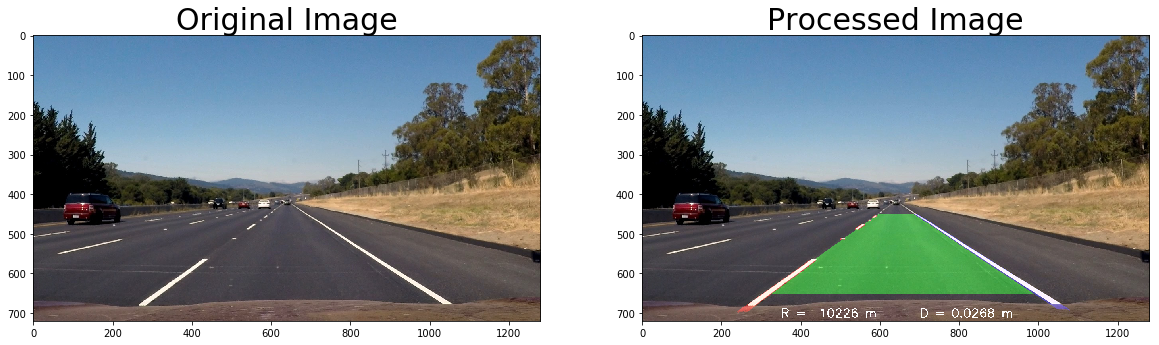

File  test1.jpg with dimensions: (720, 1280, 3)


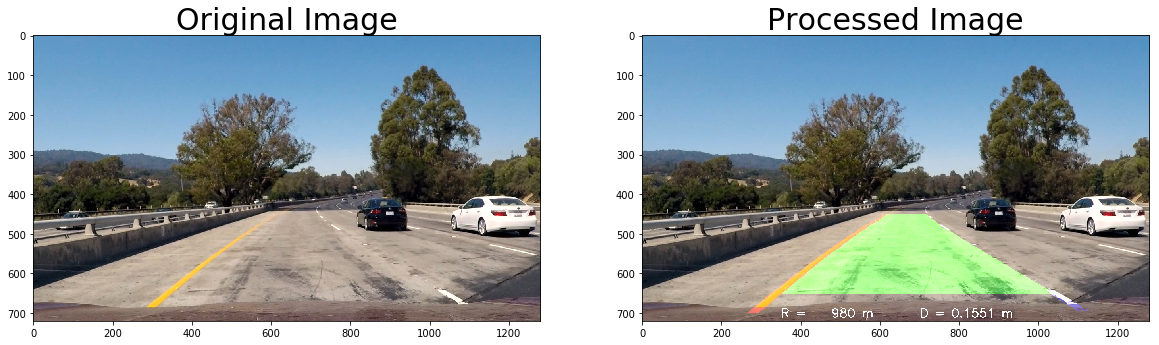

File  test2.jpg with dimensions: (720, 1280, 3)


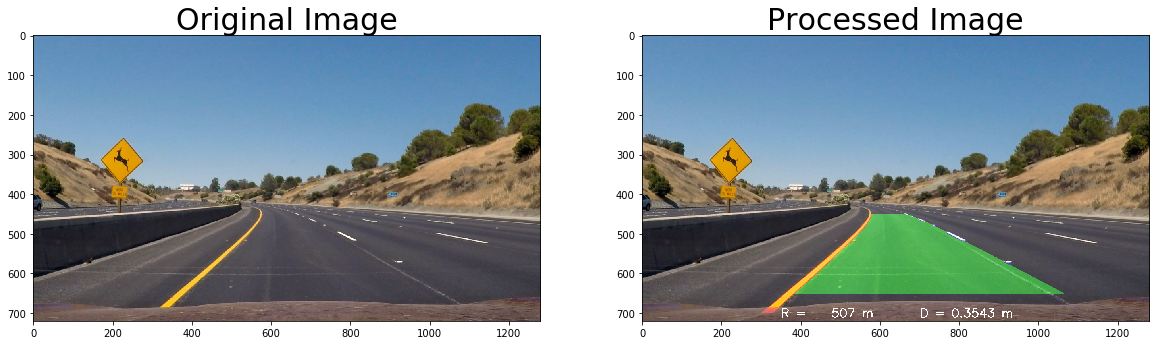

File  test3.jpg with dimensions: (720, 1280, 3)


File  test4.jpg with dimensions: (720, 1280, 3)


File  test5.jpg with dimensions: (720, 1280, 3)


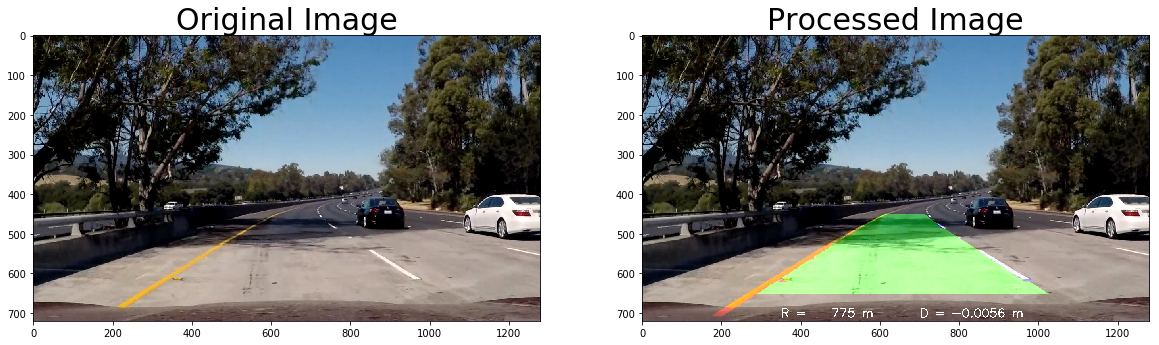

File  test6.jpg with dimensions: (720, 1280, 3)


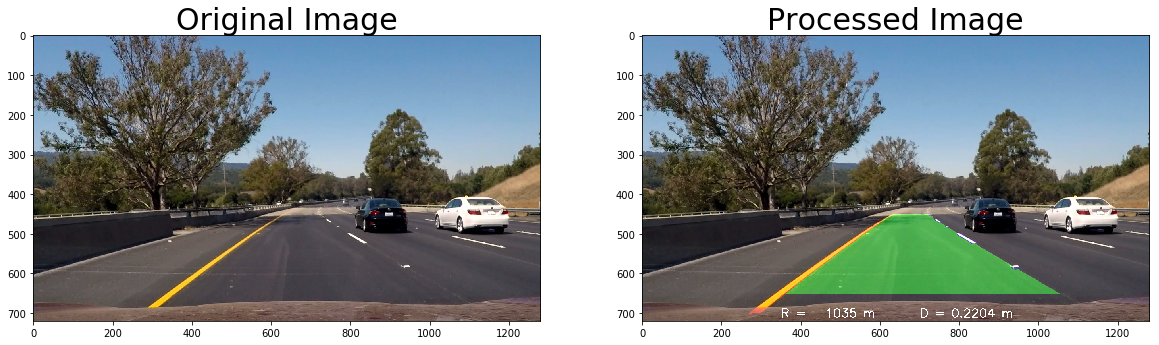

In [15]:
for inputFile in glob.glob('test_images/*.jpg'):
#for inputFile in ['test_images\\straight_lines1.jpg']:
#for inputFile in ['test_images\\test5.jpg']:
    FileName = inputFile.split('\\')[-1]

    # Read in image
    #inputFile = "test_images/"+FileName
    image = mpimg.imread(inputFile)
    
    # Define line instances
    leftLine = None
    rightLine = None
    
    # Process image
    outputImage = pipeline(image)
    
    # Save final image
    outputFile = "test_images_output/output_"+FileName
    mpimg.imsave(outputFile, outputImage)
    
    # Visualize image processing
    print('File ', FileName, 'with dimensions:', image.shape)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(outputImage)
    ax2.set_title('Processed Image', fontsize=30)
    plt.show()

Visualize all of the steps in the pipeline by breaking it down individually.

File  straight_lines1.jpg with dimensions: (720, 1280, 3)


File  straight_lines2.jpg with dimensions: (720, 1280, 3)


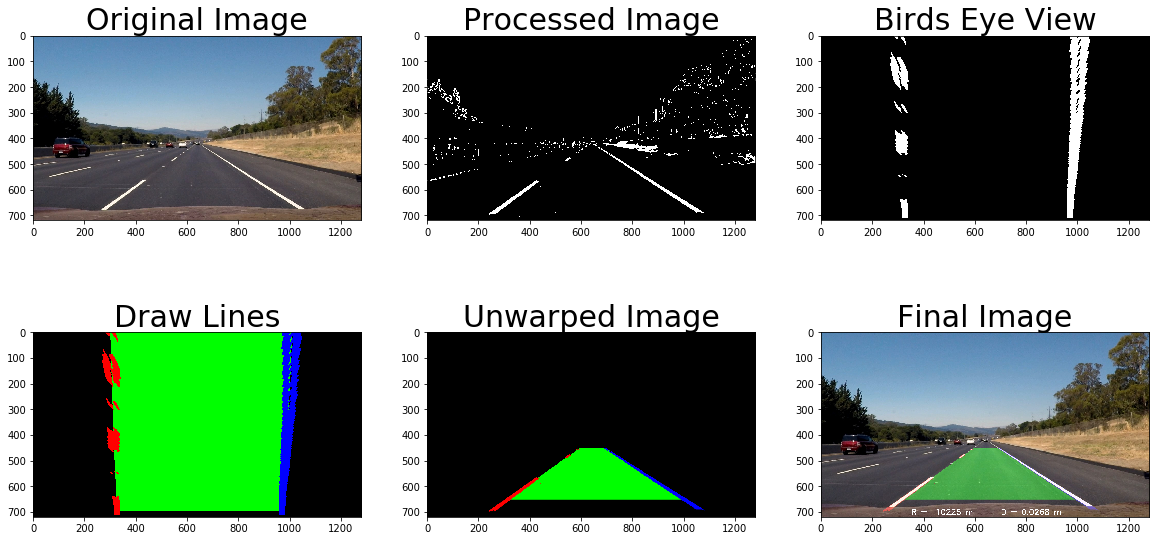

File  test1.jpg with dimensions: (720, 1280, 3)


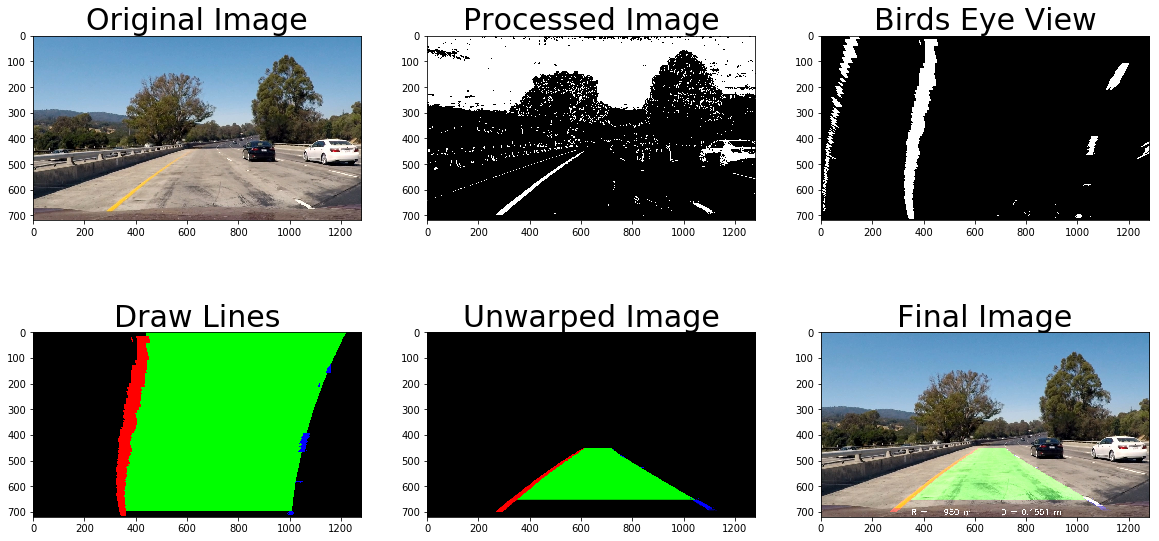

File  test2.jpg with dimensions: (720, 1280, 3)


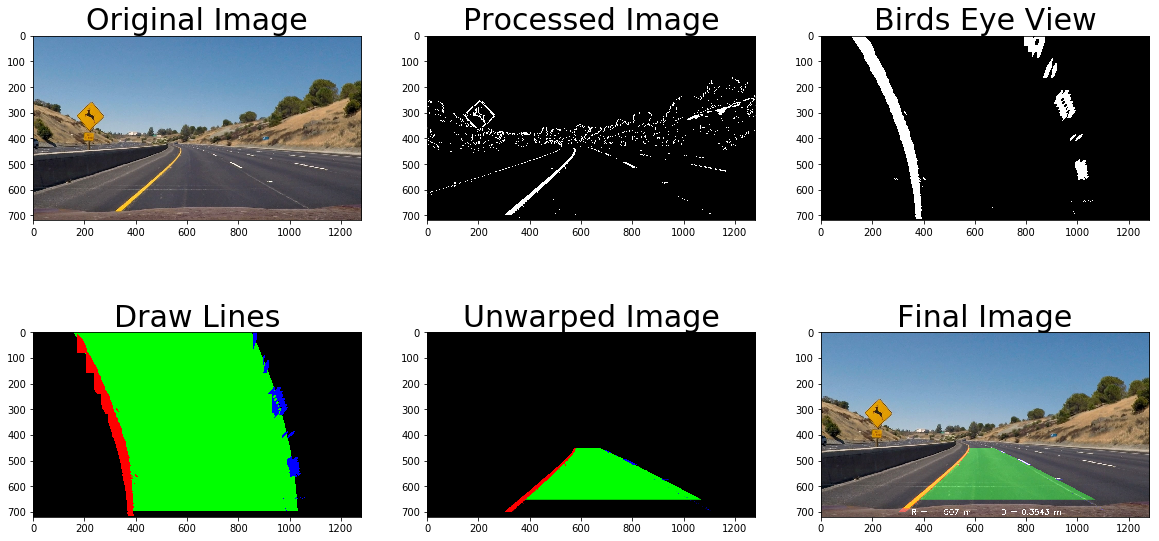

File  test3.jpg with dimensions: (720, 1280, 3)


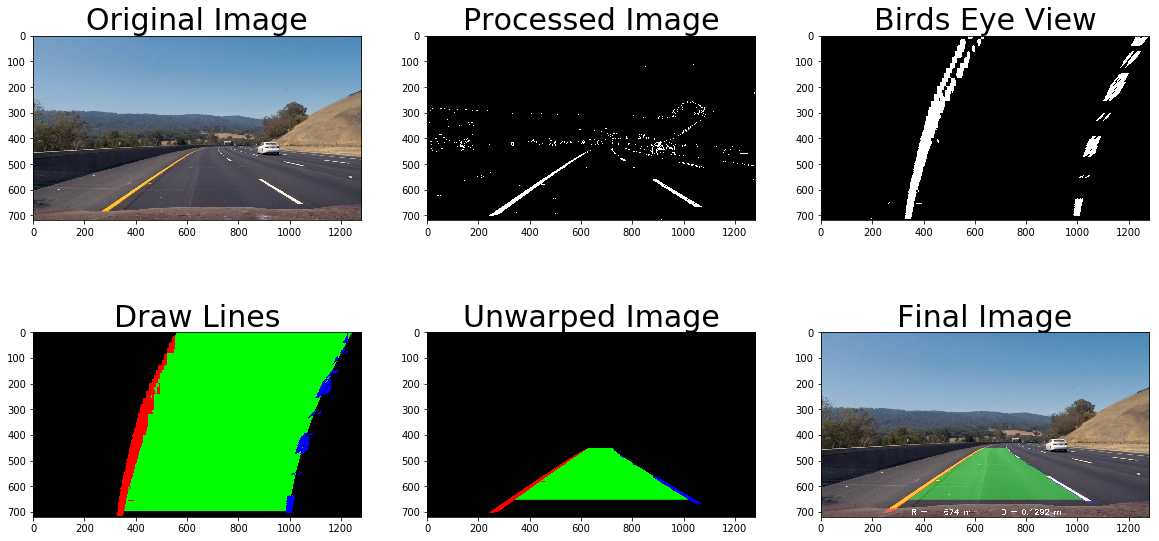

File  test4.jpg with dimensions: (720, 1280, 3)


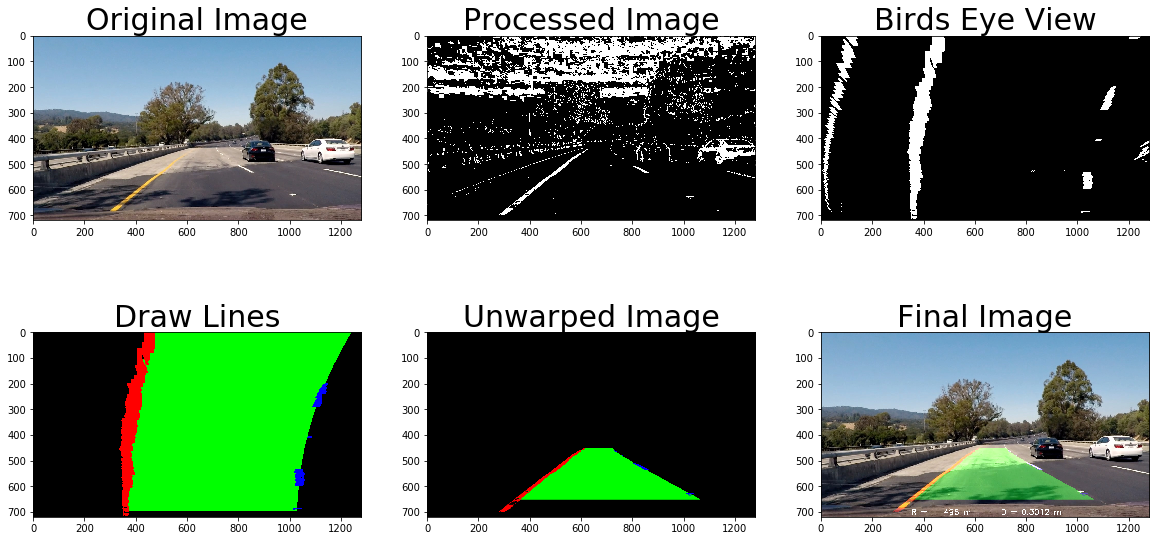

File  test5.jpg with dimensions: (720, 1280, 3)


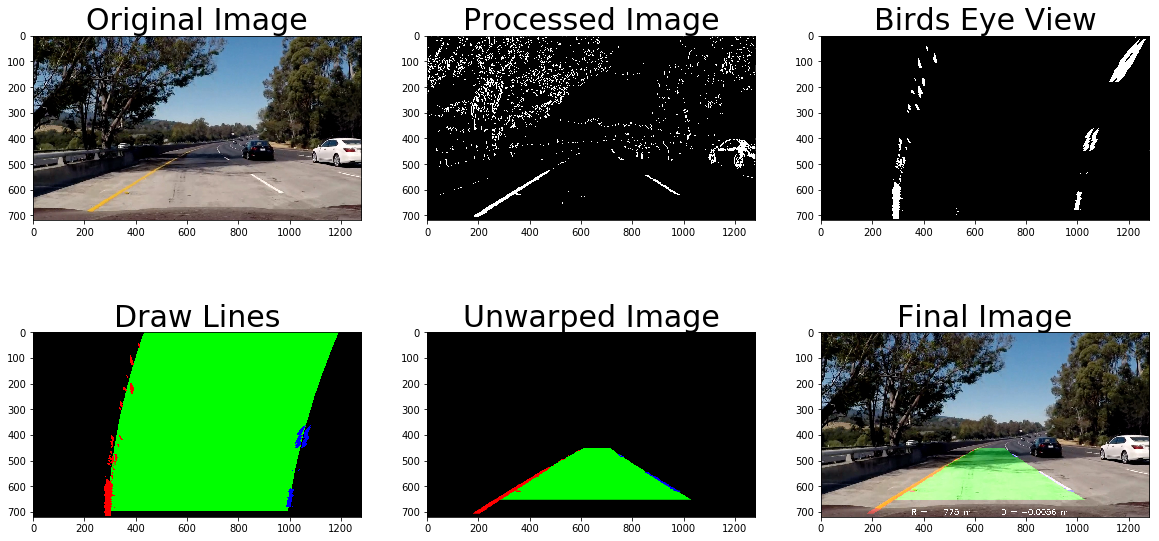

File  test6.jpg with dimensions: (720, 1280, 3)


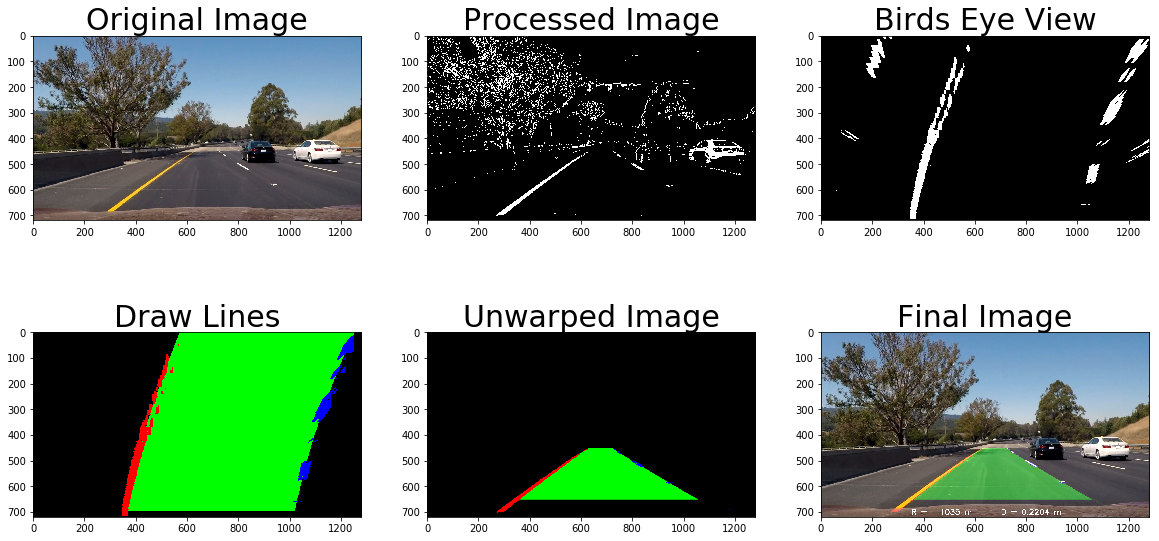

In [16]:
for inputFile in glob.glob('test_images/*.jpg'):
#for inputFile in ['test_images\\straight_lines1.jpg']:
#for inputFile in ['test_images\\test1.jpg']:
    FileName = inputFile.split('\\')[-1]

    # Read in image
    #inputFile = "test_images/"+FileName
    image = mpimg.imread(inputFile)
    
    # Define line instances
    leftLine = Line('left')
    rightLine = Line('right')
    
    # Calibrate camera
    undist = image_undistort(image, mtx, dist)
    
    # Process image and return binary image
    [binary_image, color_binary] = process_image(undist)
    
    # Change perspective view to bird's eye
    [binary_warped, M, Minv] = perspective_transform(binary_image)
    
    # Detect lines
    detect_lines(binary_warped, leftLine, rightLine)
    
    # Returns an image with lane lines annotated on it
    lines_image = draw_lines(leftLine, rightLine, img)
    
    # Reverse perspective back to original image
    output_unwarped = perspective_untransform(lines_image, Minv)
    #output_redistorted = image_redistort(output_unwarped, mtx, dist)
    
    # Combine lines image and original image
    combined_image = weighted_img(output_unwarped, image, α=1.0, β=0.4, λ=0.)
    
    # Annotate image with distance to center and radius of curvature
    annotated_image = annotate_img(leftLine, rightLine, combined_image)
    
    # Save intermediate images
    mpimg.imsave('output_images/pipeline_breakdown/undist_'+FileName, undist)
    mpimg.imsave('output_images/pipeline_breakdown/binary_'+FileName, binary_image)
    mpimg.imsave('output_images/pipeline_breakdown/binary_warped_'+FileName, binary_warped)
    mpimg.imsave('output_images/pipeline_breakdown/lines_'+FileName, lines_image)
    mpimg.imsave('output_images/pipeline_breakdown/lines_unwarped_'+FileName, output_unwarped)
    mpimg.imsave('output_images/pipeline_breakdown/final_'+FileName, annotated_image)
    
    # Visualize image processing
    print('File ', FileName, 'with dimensions:', image.shape)
    f, axes = plt.subplots(2, 3, figsize=(20,10))
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image', fontsize=30)
    axes[0, 1].imshow(binary_image, cmap='gray')
    axes[0, 1].set_title('Processed Image', fontsize=30)    
    axes[0, 2].imshow(binary_warped, cmap='gray')
    axes[0, 2].set_title('Birds Eye View', fontsize=30)
    axes[1, 0].imshow(lines_image)
    axes[1, 0].set_title('Draw Lines', fontsize=30)
    axes[1, 1].imshow(output_unwarped)
    axes[1, 1].set_title('Unwarped Image', fontsize=30)
    axes[1, 2].imshow(annotated_image)
    axes[1, 2].set_title('Final Image', fontsize=30)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
images = glob.glob('*.mp4')
pprint.pprint(images)

['challenge_video.mp4', 'harder_challenge_video.mp4', 'project_video.mp4']


In [19]:
global leftLine
global rightLine

#for inputFile in glob.glob('*.mp4'):
for inputFile in ['project_video.mp4']:
    FileName = inputFile

    # Read in video
    clip = VideoFileClip(inputFile)#.subclip(38,42)
        
    # Define line instances
    leftLine = Line('left')
    rightLine = Line('right')
    
    # Process video
    output_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
    
    # Save final image
    outputFile = "test_videos_output/output_"+FileName
    %time output_clip.write_videofile(outputFile, audio=False)
    
    del clip, output_clip

[MoviePy] >>>> Building video test_videos_output/output_project_video.mp4
[MoviePy] Writing video test_videos_output/output_project_video.mp4


100%|█████████████████████████████████████████▉| 1260/1261 [19:51<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_project_video.mp4 

Wall time: 19min 52s


In [20]:
video_file = 'test_videos_output/output_project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
